# Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, wilcoxon, ranksums
from itertools import combinations

CSV Fields
* - ID => corresponds to the Duration (in seconds) column
* - Groups => by FL_20_DO_RandomizationA ... FL_20_DO_RandomizationL These 12 columns are collectively decided
* - Scen_Danger => is derived from the 8 columns of text values (High/Medium/Low) of [Q1035, Q1037, Q1167, Q1173, Q1179, Q1185, Q1191, Q1197].
* - Demo_Confidence => is mapped by column Q1123
* - Interv_Objectivity => is mapped by column Q1126
* - Demo_Human = > Risk Assessment column
* - Demo_AI = > ML alg column
* - Perc = > the average value NULL of the 8 columns Q293, Q294, Q295, Q296, Q32, Q34, Q36, QID13

In [2]:
# 1. Read the raw data (assume the file name is data.csv)
df = pd.read_csv('data_after_clean.csv', encoding='utf-8', dtype=str)  
# The dtype=str forces all columns to be read as strings for mapping purposes later; adjust if specific formats are needed in the raw data.

# 2. Define required column names for later access
# You specified the following columns to generate a new table:
# - ID => Corresponds to the Duration (in seconds) column
# - Groups => Determined by the columns FL_20_DO_RandomizationA ... FL_20_DO_RandomizationL
# - Scen_Danger => Derived from the textual values (High/Medium/Low) in columns [Q1035, Q1037, Q1167, Q1173, Q1179, Q1185, Q1191, Q1197]
# - Demo_Confidence => Mapped from column Q1123
# - Interv_Objectivity => Mapped from column Q1126
# - Demo_Human => Mapped from the Risk Assessment column
# - Demo_AI => Mapped from the ML alg column
# - Perc => The average of columns Q293, Q294, Q295, Q296, Q32, Q34, Q36, QID13

# 2.1 Prepare the column names we will use (adjust if column names differ):
duration_col = 'Duration (in seconds)'
risk_assessment_col = 'Risk Assessment'
ml_alg_col = 'ML alg'

# Columns related to random grouping (Groups column)
group_cols = [
    'FL_20_DO_RandomizationA','FL_20_DO_RandomizationB','FL_20_DO_RandomizationC',
    'FL_20_DO_RandomizationD','FL_20_DO_RandomizationE','FL_20_DO_RandomizationF',
    'FL_20_DO_RandomizationG','FL_20_DO_RandomizationH','FL_20_DO_RandomizationI',
    'FL_20_DO_RandomizationJ','FL_20_DO_RandomizationK','FL_20_DO_RandomizationL'
]

# Columns related to Danger scenarios
danger_cols = [
    'Q1035','Q1037','Q1167','Q1173','Q1179','Q1185','Q1191','Q1197'
]

# Demo_Confidence (Metric1) corresponding column
q1123_col = 'Q1123'

# Interv_Objectivity (Metric2) corresponding column
q1126_col = 'Q1126'

# Columns to average for Perc
perc_cols = ['Q293','Q294','Q295','Q296','Q32','Q34','Q36','QID13']

# 3. Define mapping rules for each column

# 3.1 Demo_Confidence => Mapping for Q1123
#     "I'm not confident at all" => 1
#     "I'm slightly confident"   => 2
#     "I'm somewhat confident"   => 3
#     "I'm fairly confident"     => 4
#     "I'm completely confident" => 5
confidence_map = {
    "I'm not confident at all": 1,
    "I'm slightly confident": 2,
    "I'm somewhat confident": 3,
    "I'm fairly confident": 4,
    "I'm completely confident": 5
}

# 3.2 Interv_Objectivity => Mapping for Q1126
#     "Strongly Disagree" => 1
#     "Disagree"          => 2
#     "Neither agree nor disagree" => 3
#     "Somewhat agree"    => 4
#     "Strongly agree"    => 5
objectivity_map = {
    "Strongly Disagree": 1,
    "Disagree": 2,
    "Neither agree nor disagree": 3,
    "Somewhat agree": 4,
    "Strongly agree": 5
}

# 3.3 Demo_Human => Mapping for Risk Assessment
#     "No experience" => 1
#     "As part of University projects" => 2
#     "Performed one or two risk assessment projects outside of university" => 3
human_map = {
    "No experience": 1,
    "As part of University projects": 2,
    "Performed one or two risk assessment projects outside of university": 3
}

# 3.4 Demo_AI => Mapping for ML alg
#     "No experience" => 1
#     "As part of University projects" => 2
#     "Used one or two ML algorithms outside of university" => 3
#     "Used several ML algorithms outside of university"    => 4
ai_map = {
    "No experience": 1,
    "As part of University projects": 2,
    "Used one or two ML algorithms outside of university": 3,
    "Used several ML algorithms outside of university": 4
}

# 3.5 Perc => Columns Q293, Q294, Q295, Q296, Q32, Q34, Q36, QID13, mapped and averaged
#     These columns may also contain values like "Strongly Disagree", "Disagree", etc., which need the same mapping.
#     Assuming the same mapping as objectivity_map:
perc_map = {
    "Poor": 1,
    "Strongly Disagree": 1,
    "Acceptable": 3,
    "Neutral": 3,
    "Neither agree nor disagree": 3,
    "Good": 5,
    "Strongly agree": 5
}

def map_scale_value(x, mapping):
    """Map a given string x to a number using the mapping; return None if not in mapping."""
    if pd.isnull(x):
        return None
    return mapping.get(x.strip(), None)

# 3.6 Scen_Danger => Derived from textual values (High / Medium / Low) in Q1035, Q1037, Q1167, Q1173, Q1179, Q1185, Q1191, Q1197
danger_priority = {"High": 3, "Medium": 2, "Low": 1}

def calc_scen_danger(row):
    """
    row: A complete row containing danger_cols
    If there are different textual values (High/Medium/Low) in these 8 columns, choose the most frequent one.
    """
    count_dict = {"High": 0, "Medium": 0, "Low": 0}
    for col in danger_cols:
        val = row.get(col, None)
        if val in count_dict:
            count_dict[val] += 1

    # Find the most frequent value
    chosen_text = max(count_dict, key=count_dict.get)
    if count_dict[chosen_text] == 0:
        return None  # Return None if no value is present
    return chosen_text  # Return High/Medium/Low or None

# 3.7 Groups => Based on which column in FL_20_DO_RandomizationA..L is '1' (or non-empty)
#     Assuming each row has only one column equal to '1', the group name corresponds to the respective A..L.
#     If multiple columns are '1', choose the first one (adjust logic as needed).
groups_map = {
    'FL_20_DO_RandomizationA': 'A',
    'FL_20_DO_RandomizationB': 'B',
    'FL_20_DO_RandomizationC': 'C',
    'FL_20_DO_RandomizationD': 'D',
    'FL_20_DO_RandomizationE': 'E',
    'FL_20_DO_RandomizationF': 'F',
    'FL_20_DO_RandomizationG': 'G',
    'FL_20_DO_RandomizationH': 'H',
    'FL_20_DO_RandomizationI': 'I',
    'FL_20_DO_RandomizationJ': 'J',
    'FL_20_DO_RandomizationK': 'K',
    'FL_20_DO_RandomizationL': 'L'
}
def determine_group(row):
    for col_name, group_label in groups_map.items():
        val = row.get(col_name, "")
        # Check if the current column has a value, e.g., "1"
        if pd.notnull(val) and val.strip() != "":  # or check val == '1'
            return group_label
    return None  # Return None if no group is found

# 4. Construct the output DataFrame
output_data = {
    'ID': [],  # => duration_col
    'Groups': [],
    'Scen_Danger': [],
    'Demo_Confidence': [],
    'Demo_Objectivity': [],
    'Interv_Human': [],
    'Interv_AI': [],
    'Perc': []
}

for idx, row in df.iterrows():
    # 4.1 ID column
    id_val = row.get(duration_col, None)

    # 4.2 Groups column
    group_val = determine_group(row)

    # 4.3 Scen_Danger
    scen_val = calc_scen_danger(row)

    # 4.4 Demo_Confidence => Q1123
    conf_val_str = row.get(q1123_col, None)
    conf_val = map_scale_value(conf_val_str, confidence_map)

    # 4.5 Interv_Objectivity => Q1126
    obj_val_str = row.get(q1126_col, None)
    obj_val = map_scale_value(obj_val_str, objectivity_map)

    # 4.6 Demo_Human => Risk Assessment
    rh_str = row.get(risk_assessment_col, None)
    rh_val = map_scale_value(rh_str, human_map)

    # 4.7 Demo_AI => ML alg
    ma_str = row.get(ml_alg_col, None)
    ma_val = map_scale_value(ma_str, ai_map)

    # 4.8 Perc => Average mapped values from Q293, Q294, Q295, Q296, Q32, Q34, Q36, QID13
    perc_list = []
    for pc in perc_cols:
        raw = row.get(pc, None)
        numeric_val = map_scale_value(raw, perc_map)
        if numeric_val is not None:
            perc_list.append(numeric_val)
    if len(perc_list) > 0:
        perc_val = np.mean(perc_list)
    else:
        perc_val = None

    # Add to output_data
    output_data['ID'].append(id_val)
    output_data['Groups'].append(group_val)
    output_data['Scen_Danger'].append(scen_val)
    output_data['Demo_Confidence'].append(conf_val)
    output_data['Demo_Objectivity'].append(obj_val)
    output_data['Interv_Human'].append(rh_val)
    output_data['Interv_AI'].append(ma_val)
    output_data['Perc'].append(perc_val)

# 5. Convert to DataFrame and save as CSV
result_df = pd.DataFrame(output_data)

# Note: If numeric columns (e.g., Demo_Confidence) need to retain integers or decimals, process them here.
# For example, converting Demo_Confidence, Interv_Objectivity, Demo_Human, Demo_AI to Int32
# Or rounding Perc to a specific number of decimal places

# Force numeric columns to Int or Float
int_cols = ['Demo_Confidence','Demo_Objectivity','Interv_Human','Interv_AI']
for c in int_cols:
    result_df[c] = pd.to_numeric(result_df[c], errors='coerce').astype('Int64')

# If Perc needs two decimal places, round it:
result_df['Perc'] = result_df['Perc'].round(2)

# Finally, save the file
result_df.to_csv('upload.csv', index=False, encoding='utf-8-sig')

print("The new table has been saved as 'upload.csv'.")

# Read the data into a DataFrame
df = pd.read_csv("upload.csv")

The new table has been saved as 'upload.csv'.


# Demographic Analysis

## Histograms
Distributions of data (based on groups/ scenario)

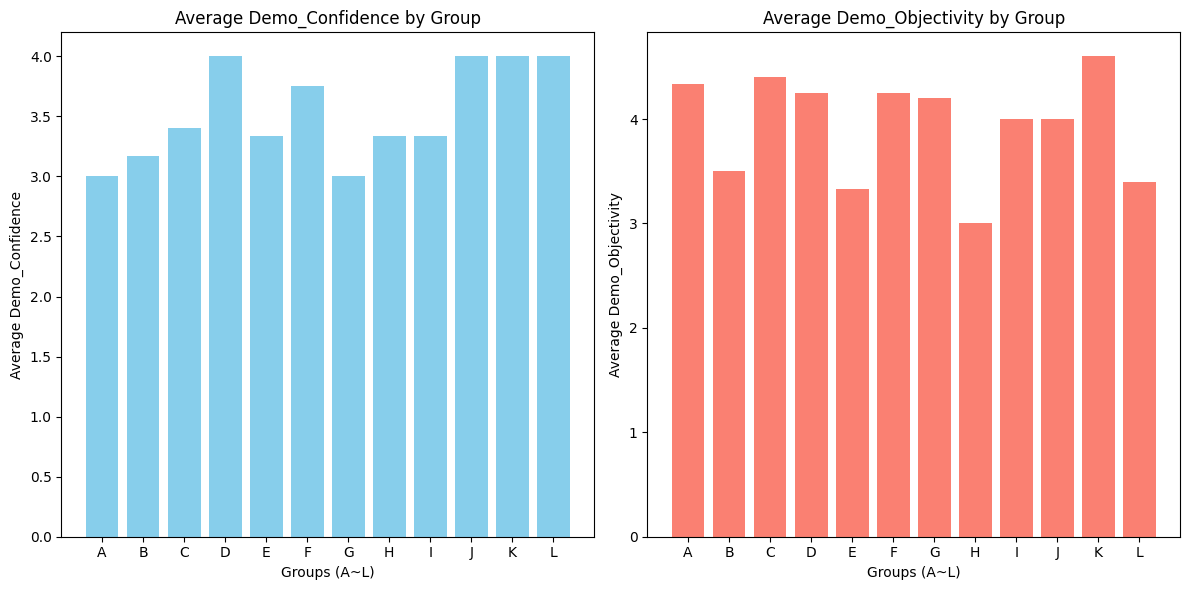

In [3]:
# Group by "Groups" and calculate the average values
grouped = df.groupby("Groups", as_index=False)[["Demo_Confidence", "Demo_Objectivity"]].mean()

# Sort the grouped results alphabetically by "Groups" (if necessary)
grouped = grouped.sort_values(by="Groups")

# Create a canvas and subplots: one row, two columns
fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=100)

# Left plot: Average Demo_Confidence
axes[0].bar(grouped["Groups"], grouped["Demo_Confidence"], color="skyblue")
axes[0].set_title("Average Demo_Confidence by Group")
axes[0].set_xlabel("Groups (A~L)")
axes[0].set_ylabel("Average Demo_Confidence")

# Right plot: Average Demo_Objectivity
axes[1].bar(grouped["Groups"], grouped["Demo_Objectivity"], color="salmon")
axes[1].set_title("Average Demo_Objectivity by Group")
axes[1].set_xlabel("Groups (A~L)")
axes[1].set_ylabel("Average Demo_Objectivity")

plt.tight_layout()
plt.show()

## Scatter plots
Represent values for two different numeric variables to compare the two variables.

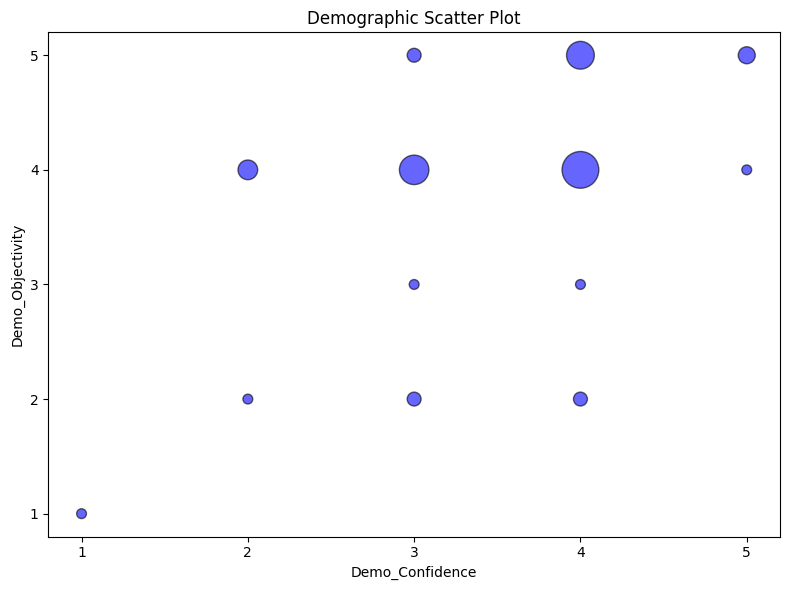

In [15]:
# Set global minimum and maximum values
MIN_DEMO1, MAX_DEMO1 = df["Demo_Confidence"].min(), df["Demo_Confidence"].max()
MIN_DEMO2, MAX_DEMO2 = df["Demo_Objectivity"].min(), df["Demo_Objectivity"].max()

# Define the plotting function
def demographic_scatter_plot(ax, data, first, second):
    # Count the occurrences of each point
    unique_points, counts = np.unique(np.c_[data[first], data[second]], return_counts=True, axis=0)
    
    # Plot the scatter plot, with point size determined by the count
    ax.scatter(
        unique_points[:, 0],  # X-axis
        unique_points[:, 1],  # Y-axis
        s=counts * 50,        # Point size related to frequency
        c="blue",             # Fixed point color is blue
        alpha=0.6,            # Transparency
        edgecolors="black"    # Black border
    )
    
    # Set the ticks for the x and y axes
    ax.set_xticks(np.arange(MIN_DEMO1, MAX_DEMO1 + 1, 1))
    ax.set_yticks(np.arange(MIN_DEMO2, MAX_DEMO2 + 1, 1))
    
    # Set axis labels and title
    ax.set_xlabel(first)
    ax.set_ylabel(second)
    ax.set_title("Demographic Scatter Plot")
    
    return ax

# Create the canvas
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)

# Call the plotting function
demographic_scatter_plot(ax, df, "Demo_Confidence", "Demo_Objectivity")

# Display the chart
plt.tight_layout()
plt.show()

# Intervention Metrics

## Boxplots
A standardized way of displaying the dataset based on the five-number summary: the minimum, the maximum, the sample median, and the first and third quartiles.

### Intervention Boxplot by Group

C:\Users\lizel\AppData\Local\Temp\ipykernel_31404\1616226579.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Groups', y='Interv_Human', data=df, ax=axes[0], palette=GROUP_COLORS)
C:\Users\lizel\AppData\Local\Temp\ipykernel_31404\1616226579.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Groups', y='Interv_AI', data=df, ax=axes[1], palette=GROUP_COLORS)


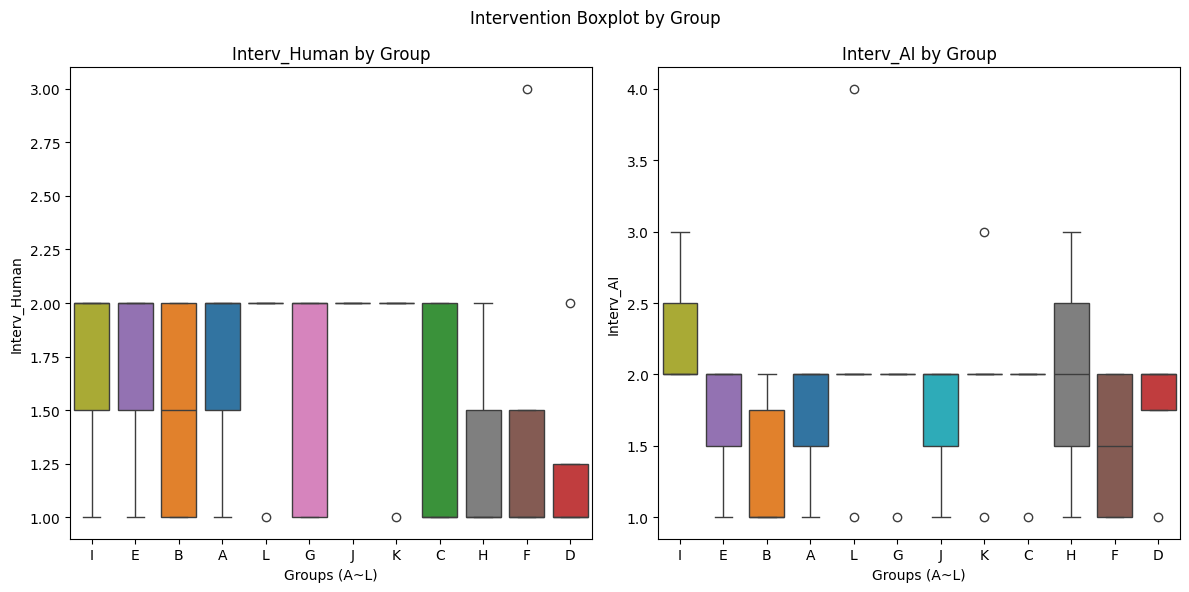

In [5]:
# Set group colors (optional)
GROUP_COLORS = {group: color for group, color in zip("ABCDEFGHIJKL", sns.color_palette("tab10", 12))}

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=100)

# Left plot: Boxplot of Interv_Human
sns.boxplot(x='Groups', y='Interv_Human', data=df, ax=axes[0], palette=GROUP_COLORS)
axes[0].set_title("Interv_Human by Group")
axes[0].set_xlabel("Groups (A~L)")
axes[0].set_ylabel("Interv_Human")

# Right plot: Boxplot of Interv_AI
sns.boxplot(x='Groups', y='Interv_AI', data=df, ax=axes[1], palette=GROUP_COLORS)
axes[1].set_title("Interv_AI by Group")
axes[1].set_xlabel("Groups (A~L)")
axes[1].set_ylabel("Interv_AI")

# Set overall title
fig.suptitle("Intervention Boxplot by Group")

# Adjust layout
plt.tight_layout()
plt.show()

### Intervention Boxplot by Scenario

C:\Users\lizel\AppData\Local\Temp\ipykernel_31404\2106016502.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Scen_Danger', y='Interv_Human', data=data, ax=axes[0], palette="Set2")
C:\Users\lizel\AppData\Local\Temp\ipykernel_31404\2106016502.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Scen_Danger', y='Interv_AI', data=data, ax=axes[1], palette="Set2")


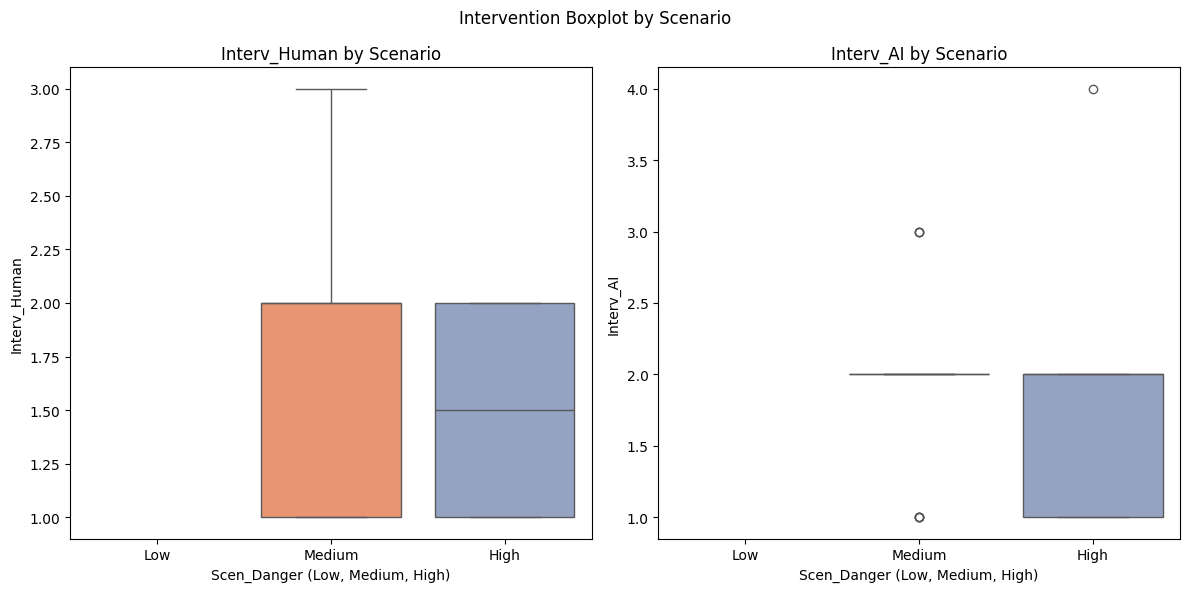

In [6]:
# Ensure Scen_Danger includes all categories (including "Low" with no data)
expected_categories = ["Low", "Medium", "High"]

# Add a row with empty values to include "Low"
if "Low" not in df["Scen_Danger"].unique():
    placeholder = pd.DataFrame({
        "Scen_Danger": ["Low"],
        "Interv_Human": [None],
        "Interv_AI": [None]
    })
    data = pd.concat([df, placeholder], ignore_index=True)

# Ensure the category order of the Scen_Danger column
data["Scen_Danger"] = pd.Categorical(data["Scen_Danger"], categories=expected_categories, ordered=True)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=100)

# Set the color palette
sns.set_palette("muted")

# Left plot: Boxplot of Interv_Human (grouped by Scen_Danger)
sns.boxplot(x='Scen_Danger', y='Interv_Human', data=data, ax=axes[0], palette="Set2")
axes[0].set_title("Interv_Human by Scenario")
axes[0].set_xlabel("Scen_Danger (Low, Medium, High)")
axes[0].set_ylabel("Interv_Human")

# Right plot: Boxplot of Interv_AI (grouped by Scen_Danger)
sns.boxplot(x='Scen_Danger', y='Interv_AI', data=data, ax=axes[1], palette="Set2")
axes[1].set_title("Interv_AI by Scenario")
axes[1].set_xlabel("Scen_Danger (Low, Medium, High)")
axes[1].set_ylabel("Interv_AI")

# Set the overall title
fig.suptitle("Intervention Boxplot by Scenario")

# Adjust layout
plt.tight_layout()
plt.show()

## Scatter plot

### Intervention Scatter Plot by Group

C:\Users\lizel\AppData\Local\Temp\ipykernel_31404\2245939219.py:22: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


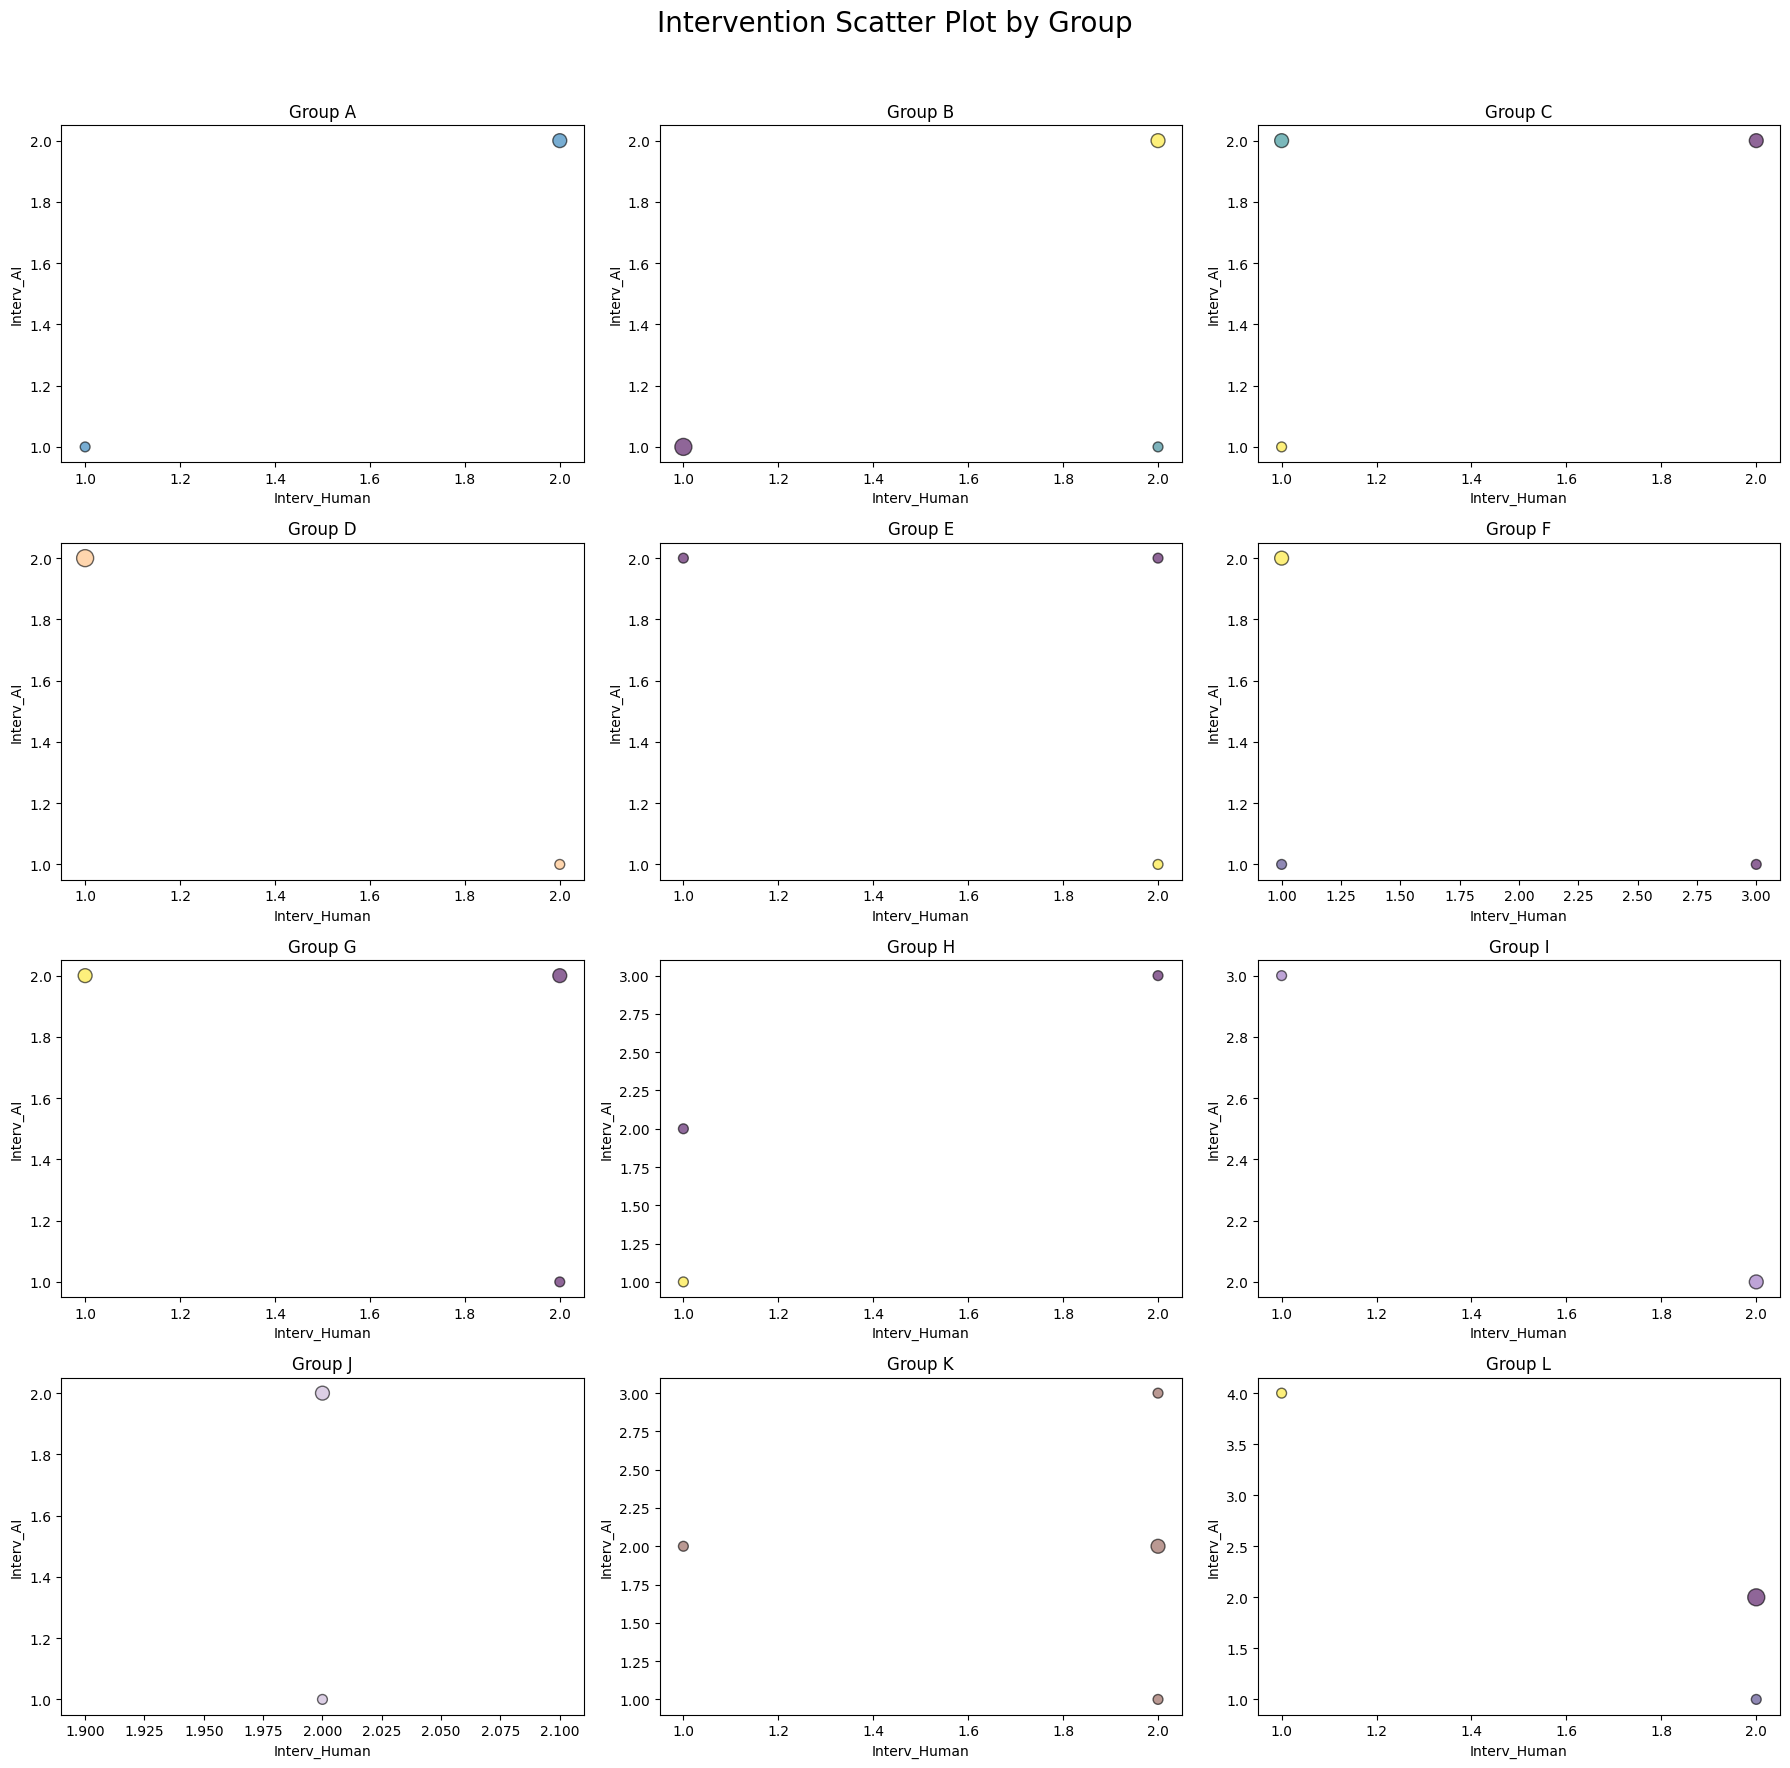

In [7]:
# Ensure the columns are numeric
df["Interv_Human"] = pd.to_numeric(df["Interv_Human"], errors='coerce')
df["Interv_AI"] = pd.to_numeric(df["Interv_AI"], errors='coerce')

# Define color mapping
GROUP_COLORS = {group: color for group, color in zip("ABCDEFGHIJKL", plt.cm.tab20.colors)}

# Define scatter_plot function
def scatter_plot(ax, data, group, groupVal, colors, first, second):
    # Filter data for the current group
    data_scatter = data[data[group] == groupVal]
    color = colors.get(groupVal, "blue")  # Default to blue if the group color is not defined

    # Count unique points and their occurrences
    unique_points, counts = np.unique(
        np.c_[data_scatter[first], data_scatter[second]],
        return_counts=True,
        axis=0
    )

    # Plot scatter plot
    ax.scatter(
        unique_points[:, 0],  # X-axis
        unique_points[:, 1],  # Y-axis
        s=counts * 50,        # Size of points related to frequency
        c=color,              # Color of points
        alpha=0.6,            # Transparency
        edgecolors="black"    # Black border
    )
    
    # Set axis labels and title
    ax.set_title(f"Group {groupVal}")
    ax.set_xlabel(first)
    ax.set_ylabel(second)

    return ax

# Create canvas and subplots: four rows, three columns, total 12 subplots
fig, axes = plt.subplots(4, 3, figsize=(18, 18), dpi=100)
axes = axes.flatten()  # Flatten the 4x3 array to a 1D array

# Plot scatter plots for each group
for i, group in enumerate("ABCDEFGHIJKL"):
    scatter_plot(axes[i], df, "Groups", group, GROUP_COLORS, "Interv_Human", "Interv_AI")

# Adjust layout and overall title
fig.suptitle("Intervention Scatter Plot by Group", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the title
plt.show()

# Perception Metric

## Histograms

### Perception Histogram

C:\Users\lizel\AppData\Local\Temp\ipykernel_31404\2289733000.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby("Groups")["Perc"].count().reset_index()


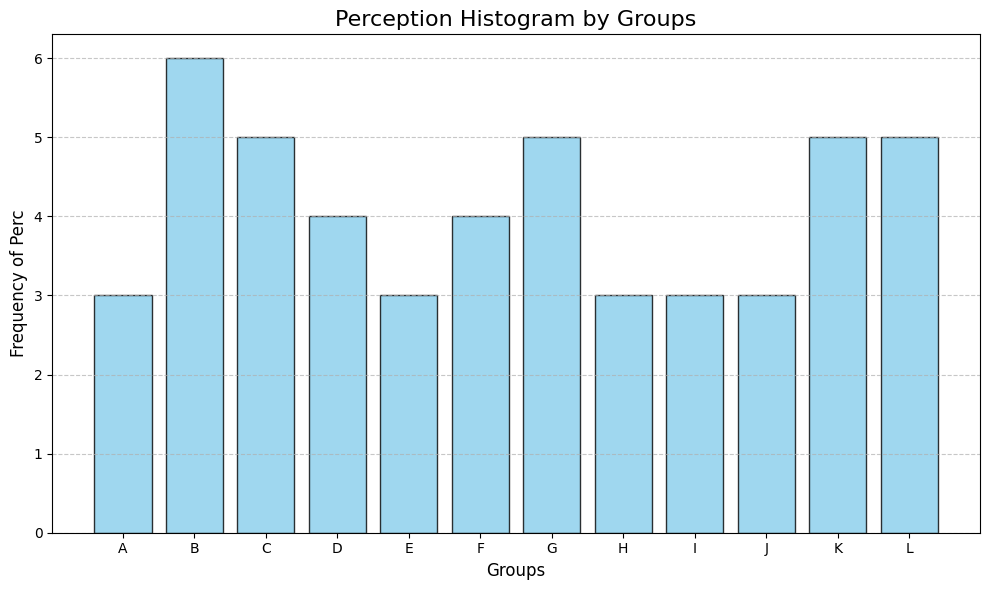

In [8]:
# Ensure the Groups column is ordered from A to L
data["Groups"] = pd.Categorical(data["Groups"], categories=list("ABCDEFGHIJKL"), ordered=True)

# Group by Groups and count the number of Perc in each group
grouped_data = data.groupby("Groups")["Perc"].count().reset_index()
grouped_data.columns = ["Groups", "Count"]  # Rename columns

# Set up the canvas
plt.figure(figsize=(10, 6))

# Plot the bar chart
plt.bar(grouped_data["Groups"], grouped_data["Count"], color="skyblue", edgecolor="black", alpha=0.8)

# Set the title and axis labels
plt.title("Perception Histogram by Groups", fontsize=16)
plt.xlabel("Groups", fontsize=12)
plt.ylabel("Frequency of Perc", fontsize=12)

# Show grid lines
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Adjust layout
plt.tight_layout()

# Display the chart
plt.show()

## Boxplots

### Perception Boxplot by Group


C:\Users\lizel\AppData\Local\Temp\ipykernel_31404\2951309968.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Groups', y='Perc', data=data, ax=ax, palette=GROUP_COLORS)


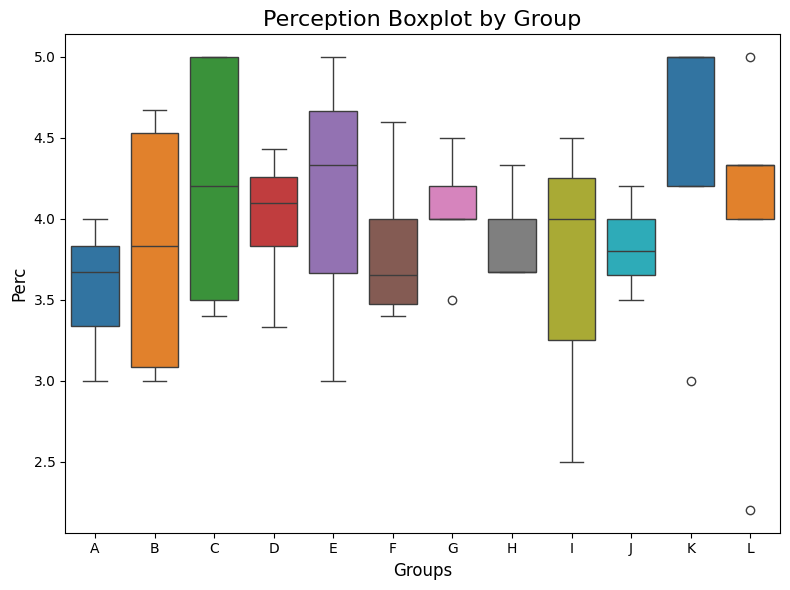

In [9]:
# Set category order, ensuring Groups are in A~L order
data["Groups"] = pd.Categorical(data["Groups"], categories=list("ABCDEFGHIJKL"), ordered=True)

# Define color mapping
GROUP_COLORS = {group: color for group, color in zip("ABCDEFGHIJKL", sns.color_palette("tab10", 12))}

# Create canvas
fig, ax = plt.subplots(figsize=(8, 6))

# Plot boxplot
sns.boxplot(x='Groups', y='Perc', data=data, ax=ax, palette=GROUP_COLORS)

# Set title and axis labels
ax.set_title("Perception Boxplot by Group", fontsize=16)
ax.set_xlabel("Groups", fontsize=12)
ax.set_ylabel("Perc", fontsize=12)

# Display chart
plt.tight_layout()
plt.show()


### Perception Boxplot by Scenario

C:\Users\lizel\AppData\Local\Temp\ipykernel_31404\2713171074.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Scen_Danger", y="Perc", data=data, palette=SCENARIO_COLORS, ax=ax)


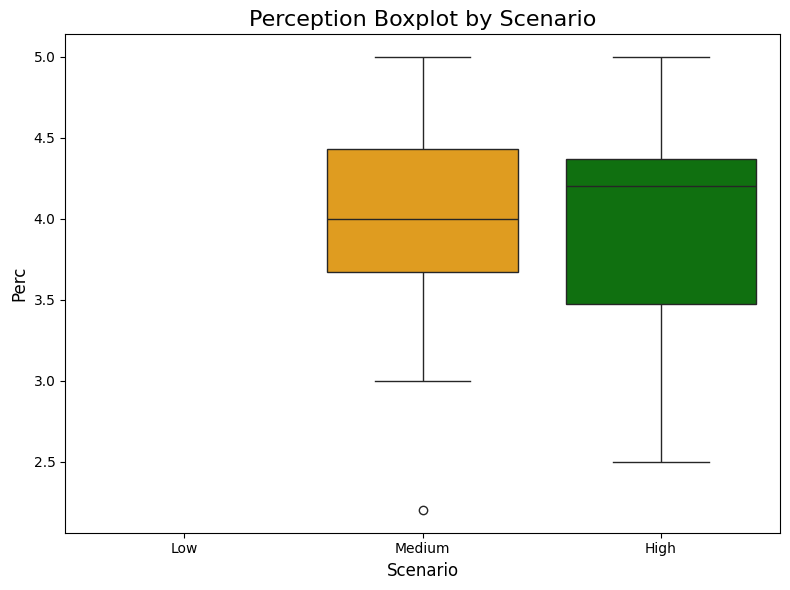

In [10]:
# Define color mapping (assuming Scenario includes Low, Medium, High)
SCENARIO_COLORS = {"Low": "skyblue", "Medium": "orange", "High": "green"}

# Ensure the category order of the Scenario column (if needed)
data["Scen_Danger"] = pd.Categorical(data["Scen_Danger"], categories=["Low", "Medium", "High"], ordered=True)

# Create the canvas
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the boxplot and specify colors
sns.boxplot(x="Scen_Danger", y="Perc", data=data, palette=SCENARIO_COLORS, ax=ax)

# Set the title and axis labels
ax.set_title("Perception Boxplot by Scenario", fontsize=16)
ax.set_xlabel("Scenario", fontsize=12)
ax.set_ylabel("Perc", fontsize=12)

# Adjust layout and display the chart
plt.tight_layout()
plt.show()

# Statistical Test

# Analyze zero vs non-zero with Chi-square and Wilcoxon

In case your metrics determine an excess of zeros we need to split the analysis in two test:


1.   A test to determine an effect by a binary distinction: zero - non zero
2.   A test to determine an effect on the non-zero part of data. Ignoring in the analysis the zeros



In [11]:
# Define thresholds for zero/non-zero
threshold_intervm1 = 3  # here your choice
threshold_intervm2 = 0  # here your choice

# Create a copy of the data for zero/non-zero analysis
data_zero_non_zero = df.copy()

# Apply thresholds to Interv_Human and Interv_AI columns (assuming these are IntervM1 and IntervM2)
data_zero_non_zero.loc[data_zero_non_zero['Interv_Human'] <= threshold_intervm1,'Interv_Human'] = 0
data_zero_non_zero.loc[data_zero_non_zero['Interv_Human'] > threshold_intervm1,'Interv_Human'] = 1

data_zero_non_zero.loc[data_zero_non_zero['Interv_AI'] <= threshold_intervm2,'Interv_AI'] = 0
data_zero_non_zero.loc[data_zero_non_zero['Interv_AI'] > threshold_intervm2,'Interv_AI'] = 1

# Chi-square test for zero/non-zero analysis
contingency_table_human = pd.crosstab(data_zero_non_zero.Groups,data_zero_non_zero.Interv_Human)
chi2_human,p_human,dof_human,_ = chi2_contingency(contingency_table_human)
print(f'Group x Interv_Human Chi_square value {chi2_human} p value {p_human} degrees of freedom {dof_human}')

contingency_table_ai = pd.crosstab(data_zero_non_zero.Groups,data_zero_non_zero.Interv_AI)
chi2_ai,p_ai,dof_ai,_ = chi2_contingency(contingency_table_ai)
print(f'Group x Interv_AI Chi_square value {chi2_ai} p value {p_ai} degrees of freedom {dof_ai}')

# Wilcoxon test for non-zero part of data (ignoring zeros)
non_zero_human = df[df['Interv_Human'] > threshold_intervm1]['Interv_Human']
non_zero_ai = df[df['Interv_AI'] > threshold_intervm2]['Interv_AI']

wilcoxon_result = wilcoxon(non_zero_human - non_zero_ai)
print(f'Wilcoxon test result: statistic={wilcoxon_result.statistic}, p-value={wilcoxon_result.pvalue}')

Group x Interv_Human Chi_square value 0.0 p value 1.0 degrees of freedom 0
Group x Interv_AI Chi_square value 0.0 p value 1.0 degrees of freedom 0
Wilcoxon test result: statistic=nan, p-value=nan


Inspect only non-zero values using Wilcoxon

In [12]:
# Define thresholds for zero/non-zero
threshold_intervm1 = 3  # here your choice
threshold_intervm2 = 0  # here your choice

# Create a copy of the data for zero/non-zero analysis
data_zero_non_zero = df.copy()

# Apply thresholds to Interv_Human and Interv_AI columns (assuming these are IntervM1 and IntervM2)
data_zero_non_zero.loc[data_zero_non_zero['Interv_Human'] <= threshold_intervm1,'Interv_Human'] = 0
data_zero_non_zero.loc[data_zero_non_zero['Interv_Human'] > threshold_intervm1,'Interv_Human'] = 1

data_zero_non_zero.loc[data_zero_non_zero['Interv_AI'] <= threshold_intervm2,'Interv_AI'] = 0
data_zero_non_zero.loc[data_zero_non_zero['Interv_AI'] > threshold_intervm2,'Interv_AI'] = 1

# Filter out zero values for non-zero analysis
data_nonzero_intervm1 = df[df['Interv_Human'] > threshold_intervm1]
data_nonzero_intervm2 = df[df['Interv_AI'] > threshold_intervm2]

# Get unique group pairs for comparison
group_pairs = list(combinations(df["Groups"].unique(), 2))

# Perform Wilcoxon rank-sum test for IntervM1 (Interv_Human)
my_groups = data_nonzero_intervm1["Groups"].unique()
for i in range(len(my_groups)):
    for j in range(i+1,len(my_groups)):
        stat,p = ranksums(x=data_nonzero_intervm1[data_nonzero_intervm1.Groups == my_groups[i]]['Interv_Human'], y=data_nonzero_intervm1[data_nonzero_intervm1.Groups == my_groups[j]]['Interv_Human'], alternative='two-sided')
        print(f"IntervM1 Group {my_groups[i]} x Group {my_groups[j]} stat = {stat}, p-value = {p}")

# Perform Wilcoxon rank-sum test for IntervM2 (Interv_AI)
my_groups = data_nonzero_intervm2["Groups"].unique()
for i in range(len(my_groups)):
    for j in range(i+1,len(my_groups)):
        stat,p = ranksums(x=data_nonzero_intervm2[data_nonzero_intervm2.Groups == my_groups[i]]['Interv_AI'], y=data_nonzero_intervm2[data_nonzero_intervm2.Groups == my_groups[j]]['Interv_AI'], alternative='two-sided')
        print(f"IntervM2 Group {my_groups[i]} x Group {my_groups[j]} stat = {stat}, p-value = {p}")

IntervM2 Group I x Group E stat = 1.091089451179962, p-value = 0.27523352407483426
IntervM2 Group I x Group B stat = 1.8073922282301278, p-value = 0.07070114486598297
IntervM2 Group I x Group A stat = 1.091089451179962, p-value = 0.27523352407483426
IntervM2 Group I x Group L stat = 0.4472135954999579, p-value = 0.6547208460185769
IntervM2 Group I x Group G stat = 1.0434983894999017, p-value = 0.2967175263220605
IntervM2 Group I x Group J stat = 1.091089451179962, p-value = 0.27523352407483426
IntervM2 Group I x Group K stat = 0.5962847939999439, p-value = 0.5509849875850934
IntervM2 Group I x Group C stat = 1.0434983894999017, p-value = 0.2967175263220605
IntervM2 Group I x Group H stat = 0.4364357804719848, p-value = 0.6625205835400574
IntervM2 Group I x Group F stat = 1.414213562373095, p-value = 0.15729920705028516
IntervM2 Group I x Group D stat = 1.0606601717798212, p-value = 0.2888443663464849
IntervM2 Group E x Group B stat = 0.7745966692414834, p-value = 0.4385780260809998
Int

## If data is ordinal, perform Wilcoxon Ranksum Tests

In case we do not have an excess of zeros we can directly apply Wilcoxon if ordinal

In [13]:
# Define thresholds for zero/non-zero
threshold_intervm1 = 3  # here your choice
threshold_intervm2 = 0  # here your choice

# Create a copy of the data for zero/non-zero analysis
data_zero_non_zero = df.copy()

# Apply thresholds to Interv_Human and Interv_AI columns (assuming these are IntervM1 and IntervM2)
data_zero_non_zero.loc[data_zero_non_zero['Interv_Human'] <= threshold_intervm1,'Interv_Human'] = 0
data_zero_non_zero.loc[data_zero_non_zero['Interv_Human'] > threshold_intervm1,'Interv_Human'] = 1

data_zero_non_zero.loc[data_zero_non_zero['Interv_AI'] <= threshold_intervm2,'Interv_AI'] = 0
data_zero_non_zero.loc[data_zero_non_zero['Interv_AI'] > threshold_intervm2,'Interv_AI'] = 1

# Filter out zero values for non-zero analysis
data_nonzero_intervm1 = df[df['Interv_Human'] > threshold_intervm1]
data_nonzero_intervm2 = df[df['Interv_AI'] > threshold_intervm2]

# Get unique scenario pairs for comparison
scenario_pairs = list(combinations(df["Scen_Danger"].unique(), 2))

# Perform Wilcoxon rank-sum test for IntervM1 (Interv_Human) based on scenarios
for pair in scenario_pairs:
    stat,p = ranksums(x=data_nonzero_intervm1[data_nonzero_intervm1.Scen_Danger == pair[0]]['Interv_Human'], y=data_nonzero_intervm1[data_nonzero_intervm1.Scen_Danger == pair[1]]['Interv_Human'], alternative='two-sided')
    print(f"IntervM1 Scenario {pair[0]} x Scenario {pair[1]} stat = {stat}, p-value = {p}")

# Perform Wilcoxon rank-sum test for IntervM2 (Interv_AI) based on scenarios
for pair in scenario_pairs:
    stat,p = ranksums(x=data_nonzero_intervm2[data_nonzero_intervm2.Scen_Danger == pair[0]]['Interv_AI'], y=data_nonzero_intervm2[data_nonzero_intervm2.Scen_Danger == pair[1]]['Interv_AI'], alternative='two-sided')
    print(f"IntervM2 Scenario {pair[0]} x Scenario {pair[1]} stat = {stat}, p-value = {p}")

IntervM1 Scenario Medium x Scenario High stat = nan, p-value = nan
IntervM2 Scenario Medium x Scenario High stat = 1.5152288168283161, p-value = 0.12971446778791298


C:\Users\lizel\AppData\Local\Temp\ipykernel_31404\377102704.py:24: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat,p = ranksums(x=data_nonzero_intervm1[data_nonzero_intervm1.Scen_Danger == pair[0]]['Interv_Human'], y=data_nonzero_intervm1[data_nonzero_intervm1.Scen_Danger == pair[1]]['Interv_Human'], alternative='two-sided')


## If data is binary, perform Chi-Square Test.

In case we do not have an excess of zeros we can directly apply Chi-Square if binary

In [14]:
# Define thresholds for zero/non-zero
threshold_intervm1 = 3  # here your choice
threshold_intervm2 = 0  # here your choice

# Create a copy of the data for zero/non-zero analysis
data_zero_non_zero = df.copy()

# Apply thresholds to Interv_Human and Interv_AI columns (assuming these are IntervM1 and IntervM2)
data_zero_non_zero.loc[data_zero_non_zero['Interv_Human'] <= threshold_intervm1,'Interv_Human'] = 0
data_zero_non_zero.loc[data_zero_non_zero['Interv_Human'] > threshold_intervm1,'Interv_Human'] = 1

data_zero_non_zero.loc[data_zero_non_zero['Interv_AI'] <= threshold_intervm2,'Interv_AI'] = 0
data_zero_non_zero.loc[data_zero_non_zero['Interv_AI'] > threshold_intervm2,'Interv_AI'] = 1

# Perform Chi-Square Test for binary data

# Group x IntervM1 (Interv_Human)
contingency_table = pd.crosstab(data_zero_non_zero.Groups,data_zero_non_zero.Interv_Human)
chi2,p,dof,_ = chi2_contingency(contingency_table)
print(f'Group x IntervM1 Chi_square value {chi2} p value {p} degrees of freedom {dof}')

# Group x IntervM2 (Interv_AI)
contingency_table = pd.crosstab(data_zero_non_zero.Groups,data_zero_non_zero.Interv_AI)
chi2,p,dof,_ = chi2_contingency(contingency_table)
print(f'Group x IntervM2 Chi_square value {chi2} p value {p} degrees of freedom {dof}')

# Scenario x IntervM1 (Interv_Human)
contingency_table = pd.crosstab(data_zero_non_zero.Scen_Danger,data_zero_non_zero.Interv_Human)
chi2,p,dof,_ = chi2_contingency(contingency_table)
print(f'Scenario x IntervM1 Chi_square value {chi2} p value {p} degrees of freedom {dof}')

# Scenario x IntervM2 (Interv_AI)
contingency_table = pd.crosstab(data_zero_non_zero.Scen_Danger,data_zero_non_zero.Interv_AI)
chi2,p,dof,_ = chi2_contingency(contingency_table)
print(f'Scenario x IntervM2 Chi_square value {chi2} p value {p} degrees of freedom {dof}')

Group x IntervM1 Chi_square value 0.0 p value 1.0 degrees of freedom 0
Group x IntervM2 Chi_square value 0.0 p value 1.0 degrees of freedom 0
Scenario x IntervM1 Chi_square value 0.0 p value 1.0 degrees of freedom 0
Scenario x IntervM2 Chi_square value 0.0 p value 1.0 degrees of freedom 0
